# Predicting Depression Using NLP

In [19]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91704\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('depression_dataset_reddit_cleaned.csv')

In [5]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [6]:
df['is_depression'].value_counts()

is_depression
0    3900
1    3831
Name: count, dtype: int64

In [7]:
df_depression = df[df['is_depression'] == 1]
df_non_depression = df[df['is_depression'] == 0]

The maximum word count in a sentence from the depression category:

In [8]:
df_depression['clean_text'].str.split(" ").apply(len).max()

4239

The maximum word count in a sentence from the non-depression category:

In [9]:
df_non_depression['clean_text'].str.split(" ").apply(len).max()

42

In [20]:

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text


In [22]:
df["clean_text"] = df["clean_text"].apply(clean)

In [24]:
x = df["clean_text"]
y = df["is_depression"]

In [30]:
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.2)

Text Vectorization

In [37]:
round(sum([len(i.split()) for i in X_train])/len(X_train))

35

In [36]:
from tensorflow.keras.layers import TextVectorization

max_vocab_length = 10000 
max_length = 34 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [38]:
from tensorflow.keras.layers import TextVectorization

max_vocab_length = 10000 
max_length = 34 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [39]:
text_vectorizer.adapt(X_train)

In [40]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:] 
print(f"Vocablary size: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words:: {bottom_5_words}")

Vocablary size: 10000
Top 5 most common words: ['', '[UNK]', 'feel', 'wa', 'like']
Bottom 5 least common words:: ['jamaophth', 'jamai', 'jaklug', 'jaim', 'jailbroken']


Embedding Layer

In [42]:

embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=max_length 
                             )

Training an LSTM Model

In [43]:
inputs = layers.Input(shape=(1,), dtype=tf.string) 
x = text_vectorizer(inputs) 
x = embedding(x) 
x = layers.LSTM(64, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs, name="model_lstm")



In [44]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [49]:
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
194/194 [==============================] - 14s 70ms/step - loss: 0.0165 - accuracy: 0.9973 - val_loss: 0.2695 - val_accuracy: 0.9354
Epoch 2/10
194/194 [==============================] - 12s 60ms/step - loss: 0.0184 - accuracy: 0.9958 - val_loss: 0.2929 - val_accuracy: 0.9231
Epoch 3/10
194/194 [==============================] - 11s 59ms/step - loss: 0.0188 - accuracy: 0.9956 - val_loss: 0.3737 - val_accuracy: 0.9198
Epoch 4/10
194/194 [==============================] - 13s 67ms/step - loss: 0.0230 - accuracy: 0.9945 - val_loss: 0.3031 - val_accuracy: 0.9147
Epoch 5/10
194/194 [==============================] - 13s 65ms/step - loss: 0.0219 - accuracy: 0.9942 - val_loss: 0.2403 - val_accuracy: 0.9334
Epoch 6/10
194/194 [==============================] - 12s 64ms/step - loss: 0.0169 - accuracy: 0.9953 - val_loss: 0.3150 - val_accuracy: 0.8914
Epoch 7/10
194/194 [==============================] - 13s 66ms/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.3250 - val_accuracy:

Thats a good accuracy 

Classification Report

In [47]:
Y_pred=model.predict(X_test)
Y_pred=(Y_pred>=0.5).astype("int")

49/49 [==============================] - 3s 17ms/step


In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       765
           1       0.96      0.91      0.94       782

    accuracy                           0.94      1547
   macro avg       0.94      0.94      0.94      1547
weighted avg       0.94      0.94      0.94      1547



In [50]:
import pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [51]:
with open('history.pkl', 'rb') as f:
    history_loaded = pickle.load(f)

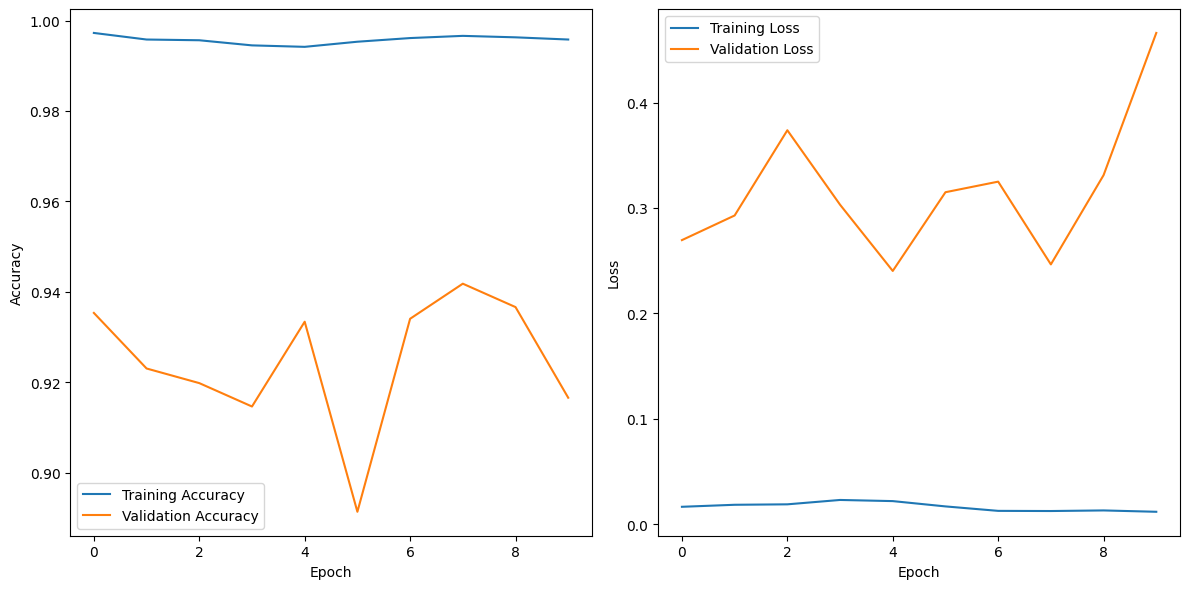

In [52]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_loaded['accuracy'], label='Training Accuracy')
plt.plot(history_loaded['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_loaded['loss'], label='Training Loss')
plt.plot(history_loaded['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
